Ingesta y lectura del archivo annotations.csv que contiene informes acústicos de la ciudad de Nueva York,fuente de datos de:"https://zenodo.org/record/3966543"

Importación de librerias a utilizar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import missingno as msno 

Ignorar mensajes de advertencias.

In [2]:
warnings.filterwarnings('ignore')

Carga del archivo y lectura del mismo.

In [39]:
# Ruta al archivo CSV
file_path = r'C:\Users\walter\Desktop\Proyecto-NYC-Taxis\Data\annotations.csv'

# Leer el archivo CSV
df_annotations = pd.read_csv(file_path)

# Primeras filas del DataFrame
print(df_annotations.head())

#Ultimas filas del Dataframe
print(df_annotations.tail())

  split  sensor_id audio_filename  annotator_id  borough  block  latitude  \
0  test          0  00_026884.wav            -6        1    547  40.72951   
1  test          0  00_026884.wav            -4        1    547  40.72951   
2  test          0  00_026884.wav            -3        1    547  40.72951   
3  test          0  00_026884.wav            -1        1    547  40.72951   
4  test          0  00_026884.wav             0        1    547  40.72951   

   longitude  year  week  ...  7-X_other-unknown-human-voice_proximity  \
0  -73.99388  2019    43  ...                                       -1   
1  -73.99388  2019    43  ...                                       -1   
2  -73.99388  2019    43  ...                                       -1   
3  -73.99388  2019    43  ...                                       -1   
4  -73.99388  2019    43  ...                                       -1   

   8-1_dog-barking-whining_proximity  1_engine_presence  \
0                                

Indentificación de valores duplicados

In [4]:
df_annotations.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
62017    False
62018    False
62019    False
62020    False
62021    False
Length: 62022, dtype: bool

Identificación de valores nulos

In [5]:
# Contar valores nulos en cada columna
null_counts = df_annotations.isnull().sum()

# Columnas con valores nulos (si hay)
null_columns = null_counts[null_counts > 0]
if len(null_columns) > 0:
    print("Columnas con valores nulos: ", null_columns)
else:
    print("No hay valores nulos en el DataFrame.")

No hay valores nulos en el DataFrame.


Verificación de outliers 

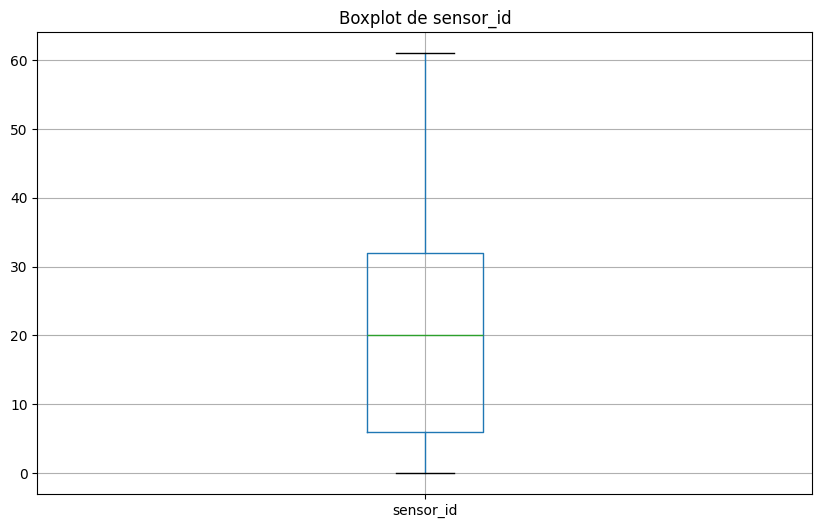

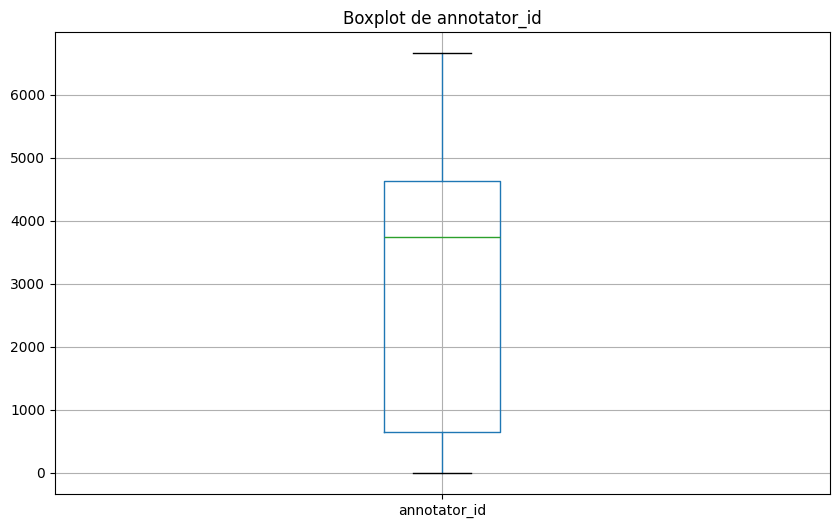

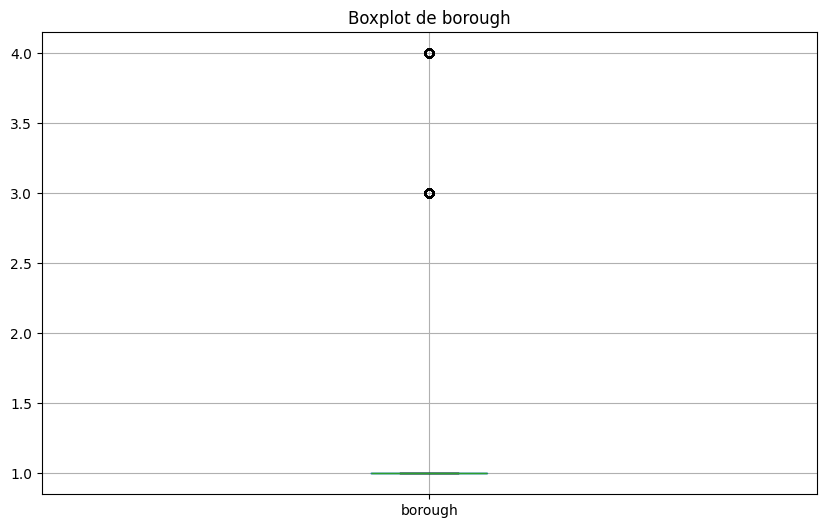

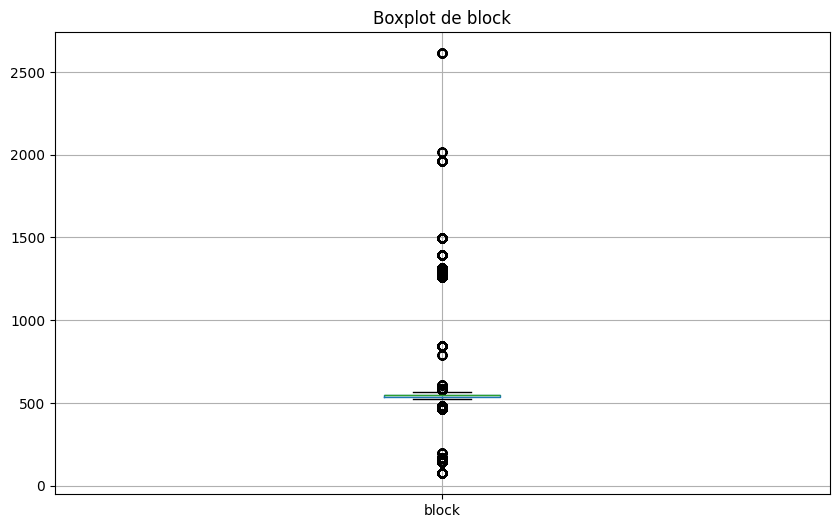

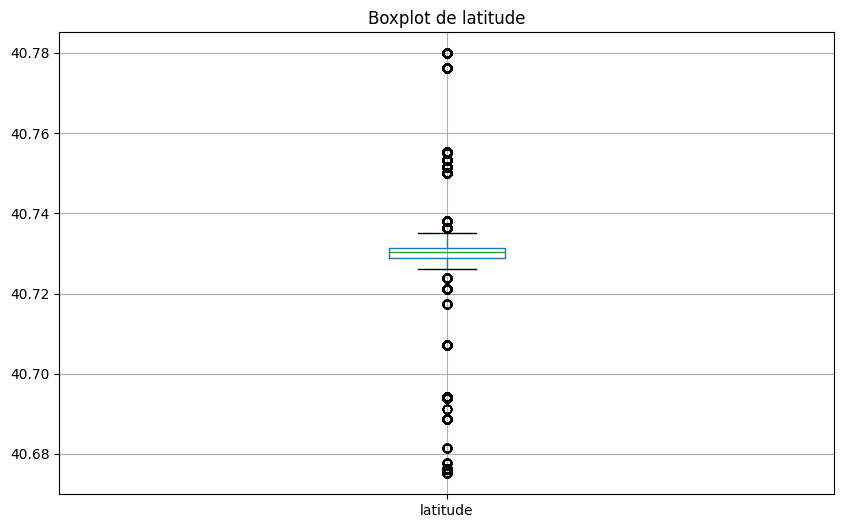

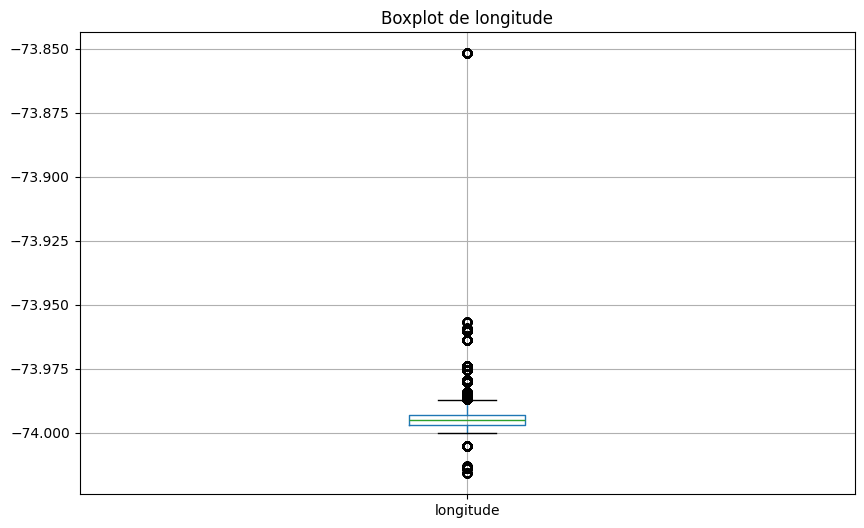

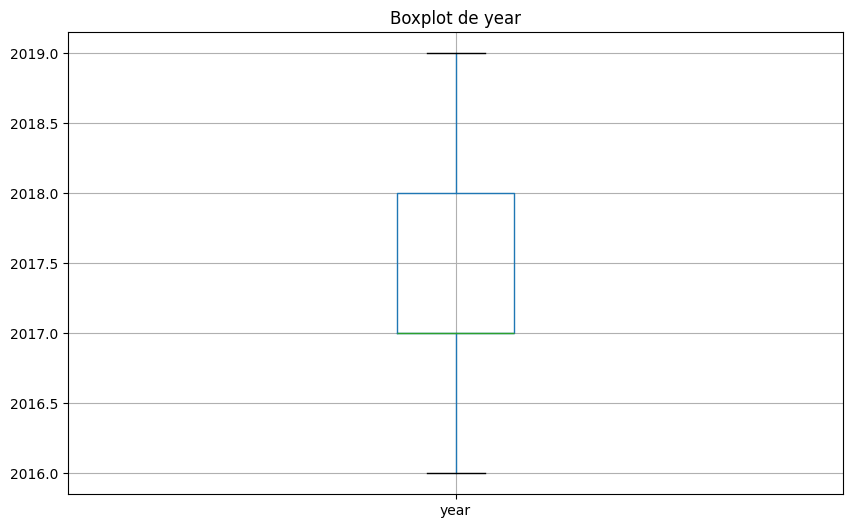

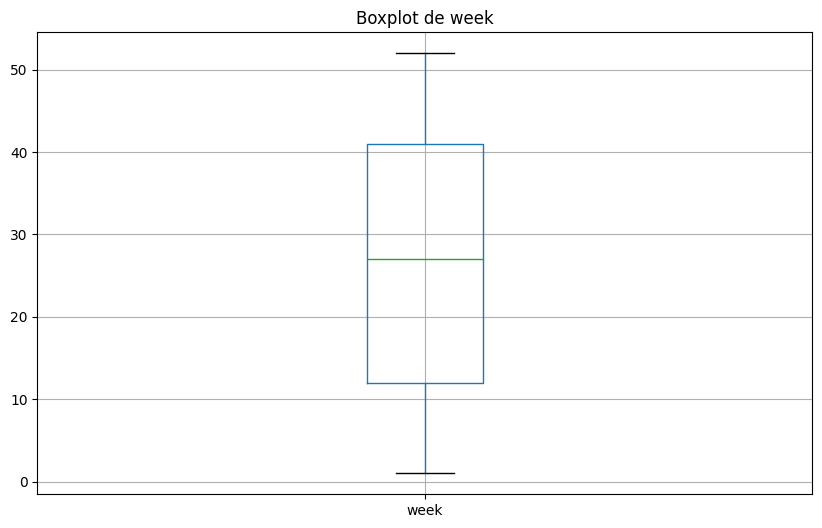

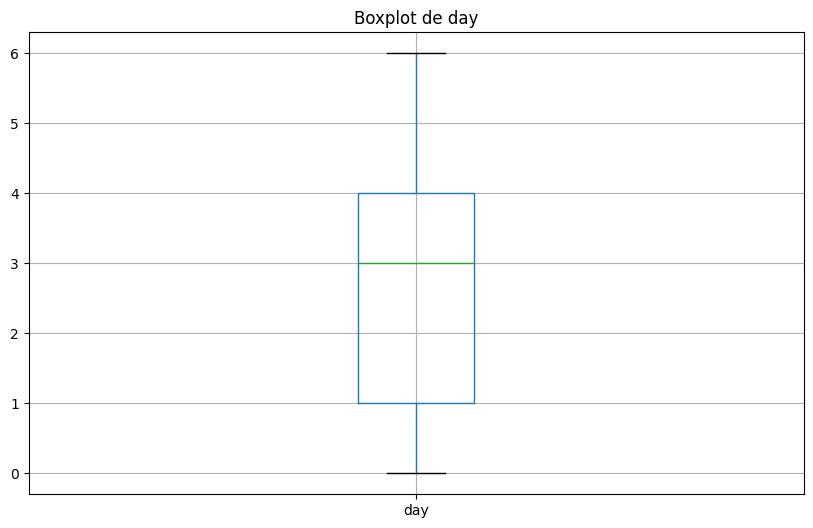

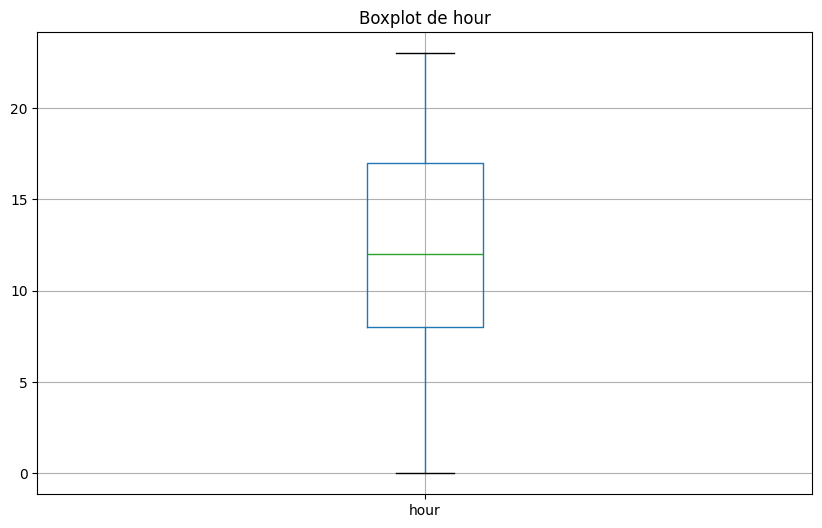

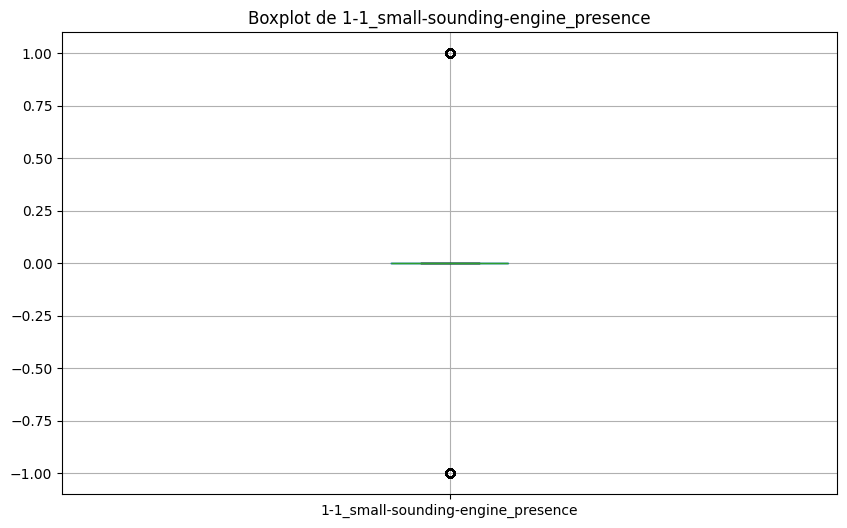

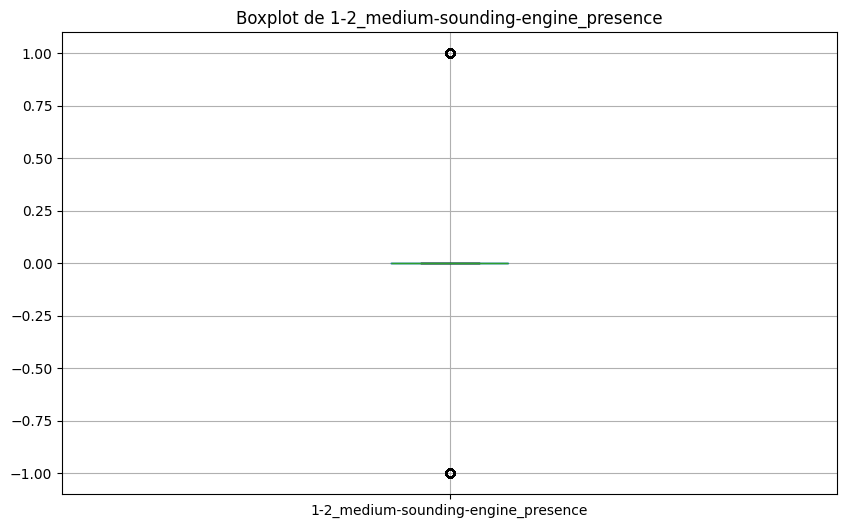

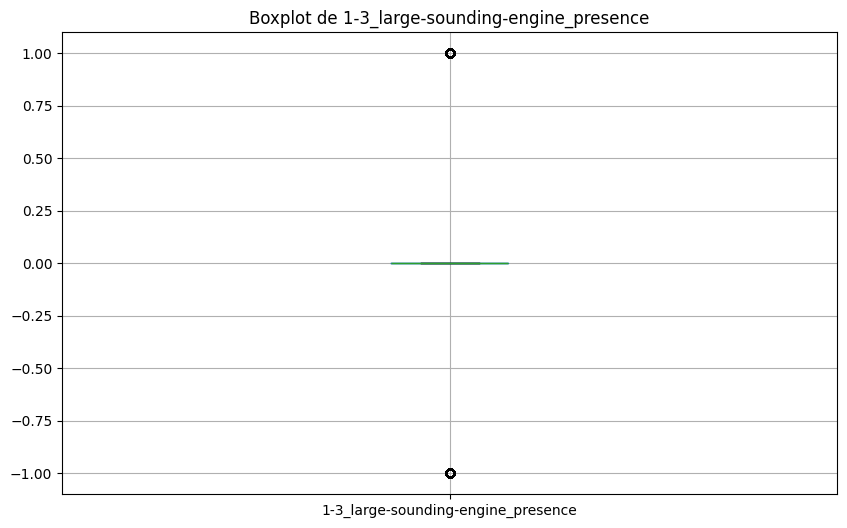

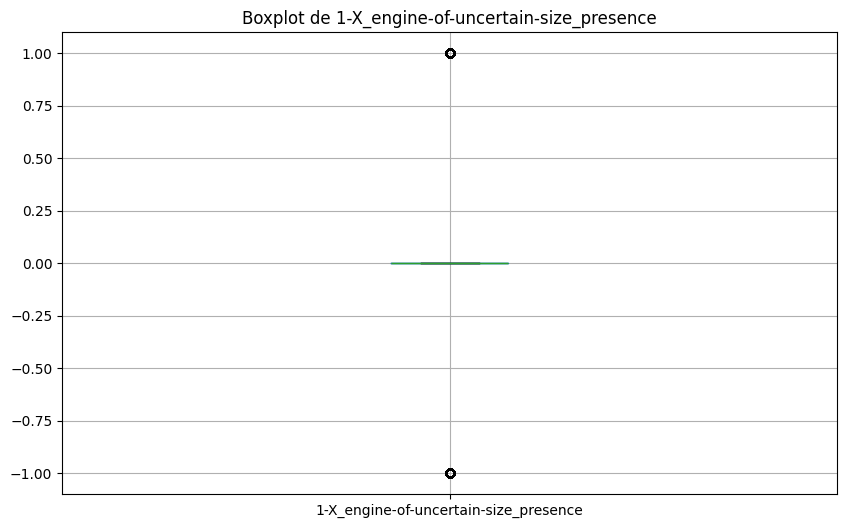

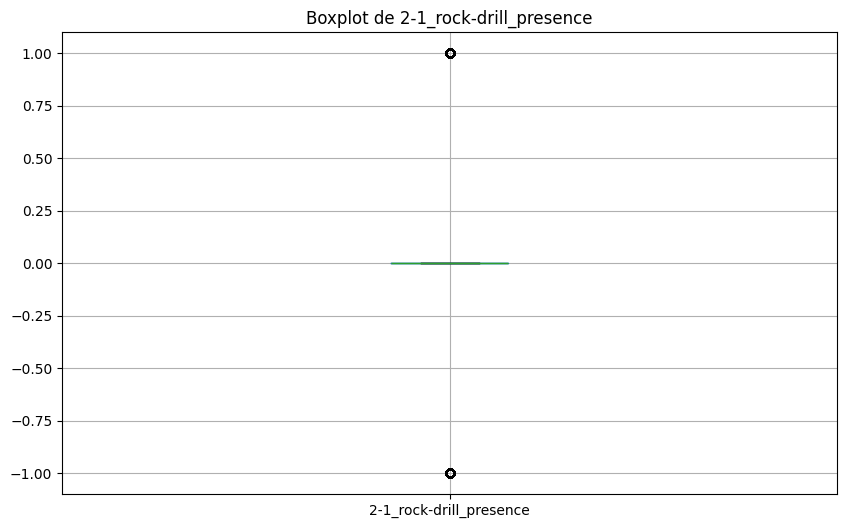

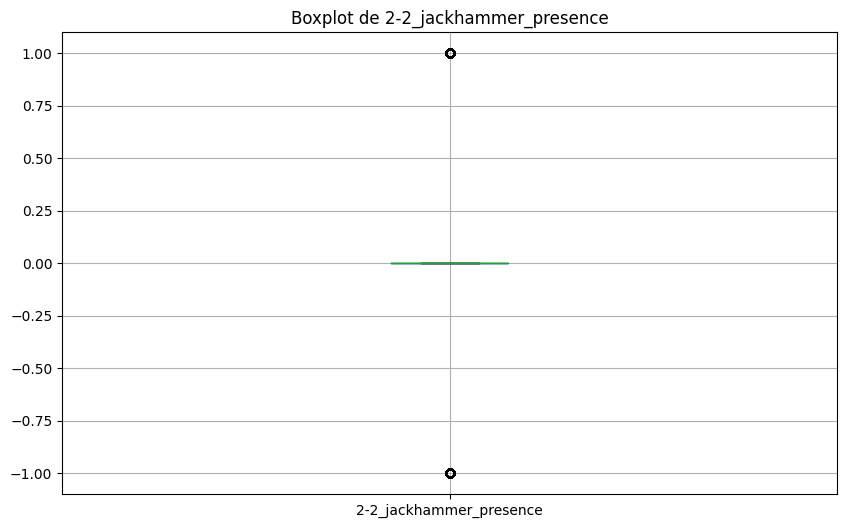

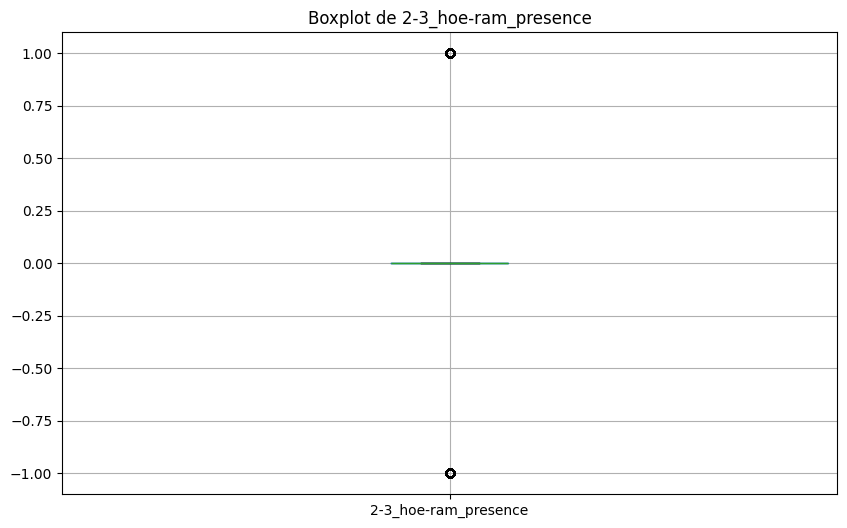

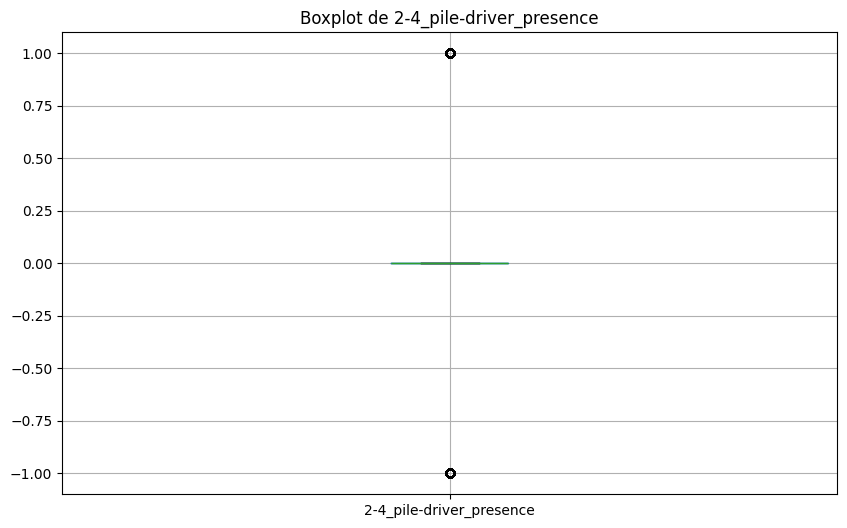

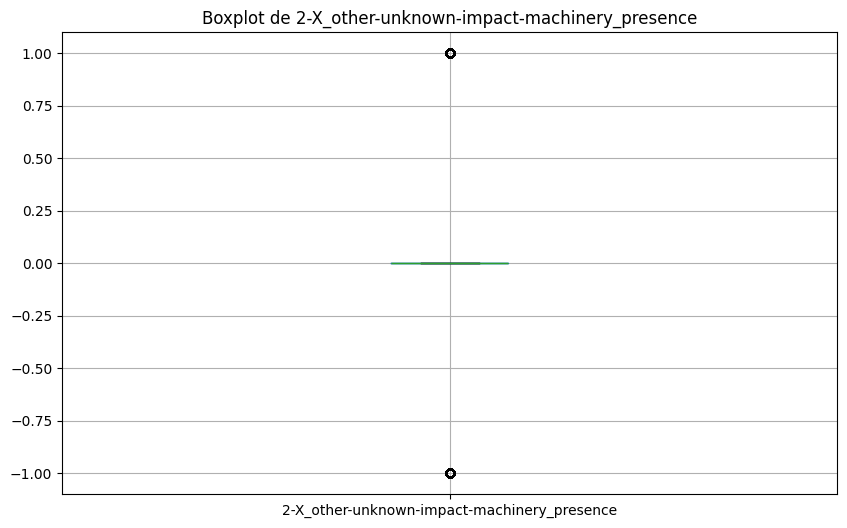

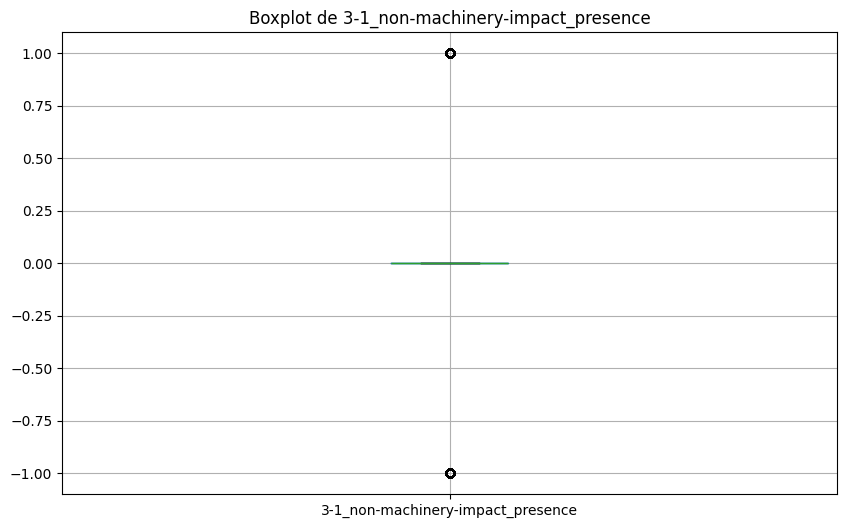

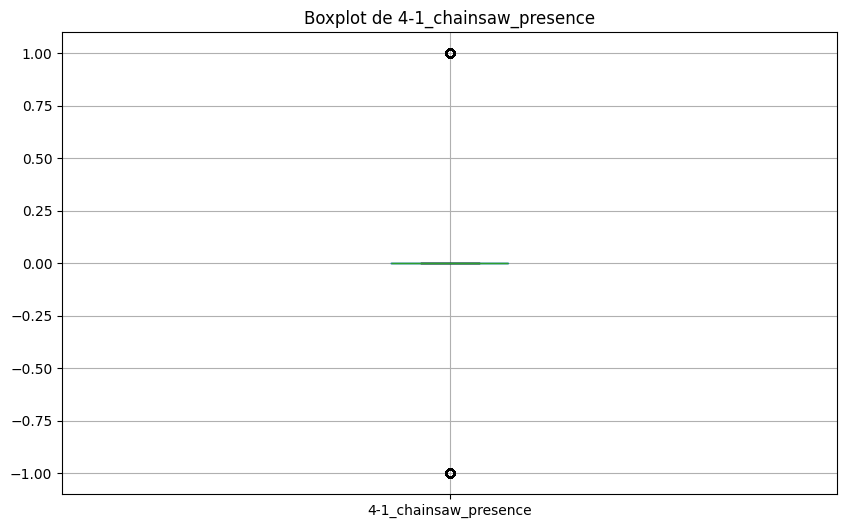

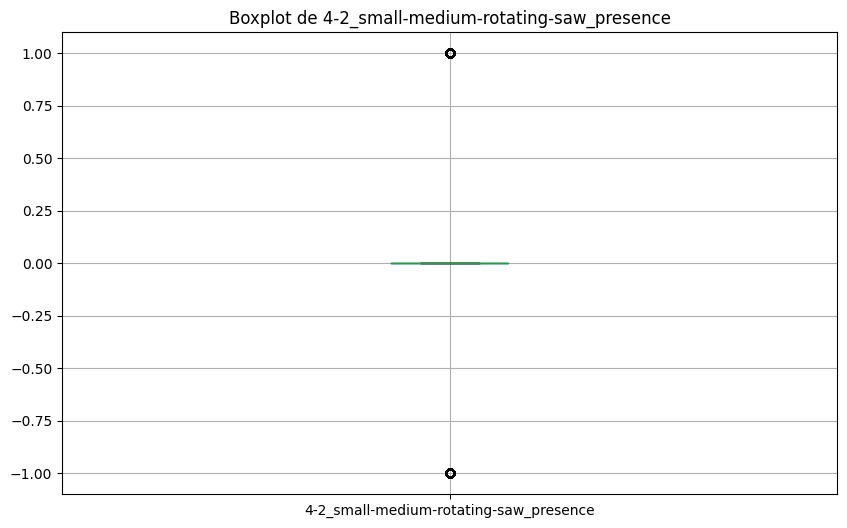

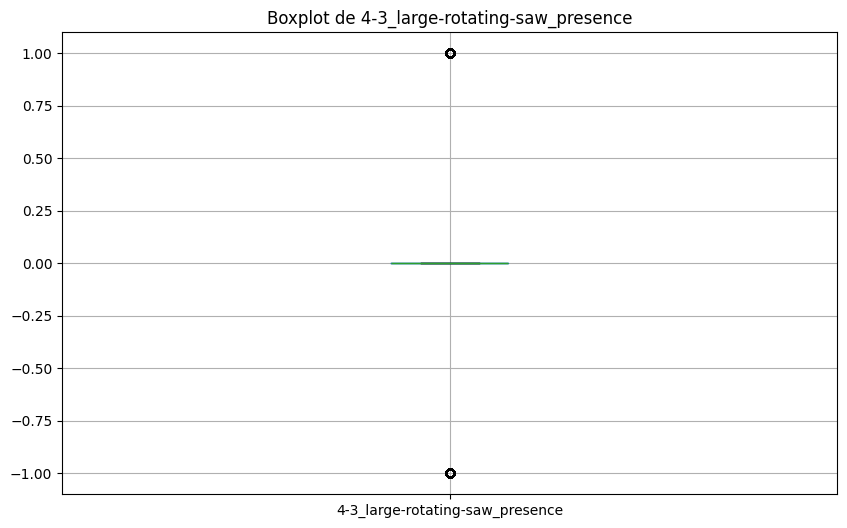

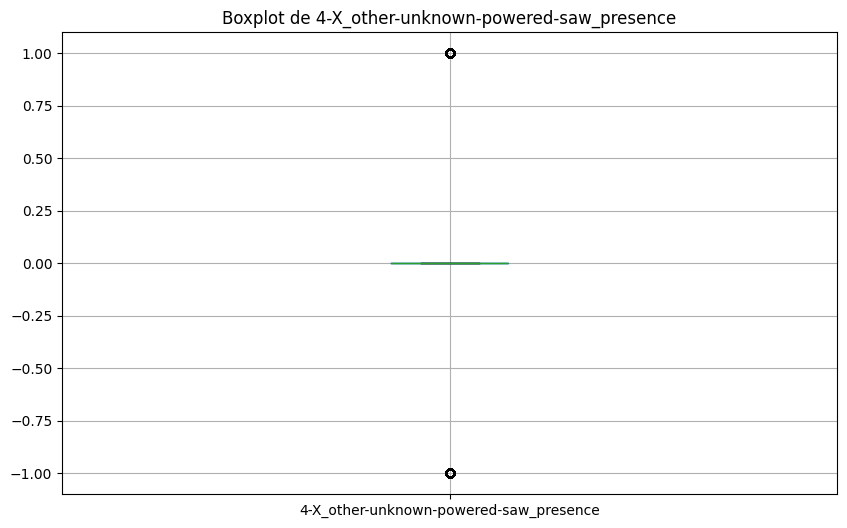

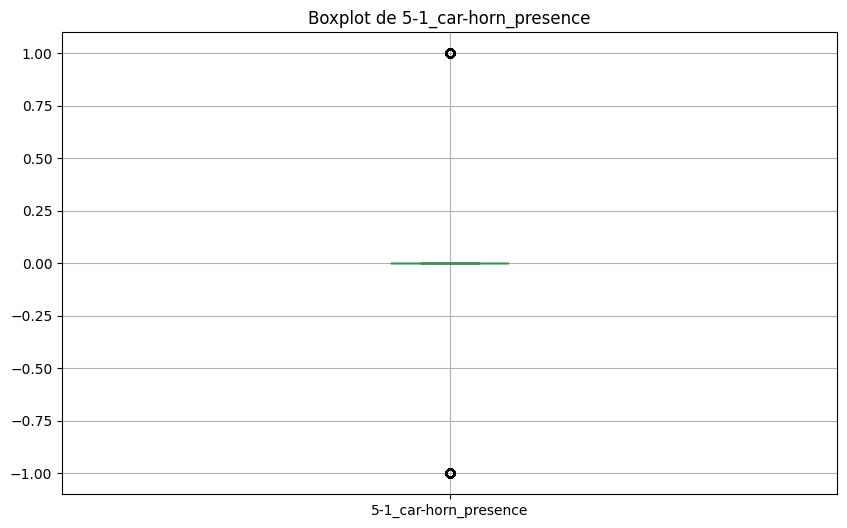

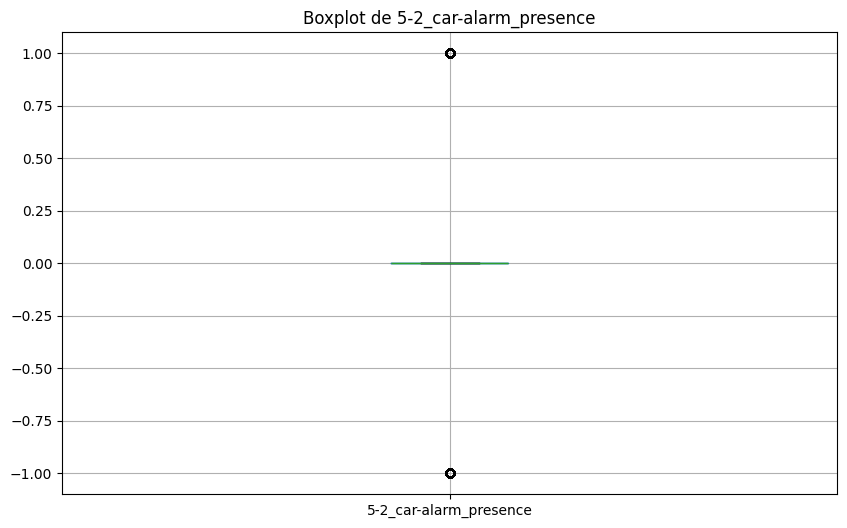

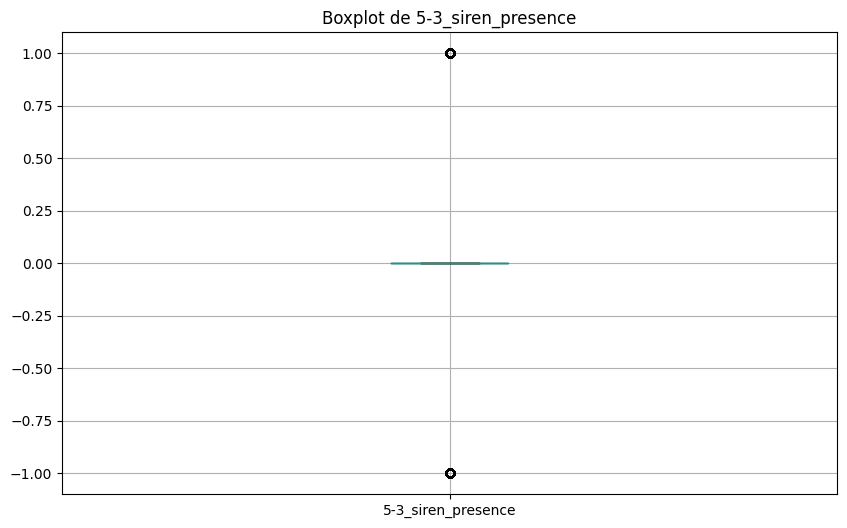

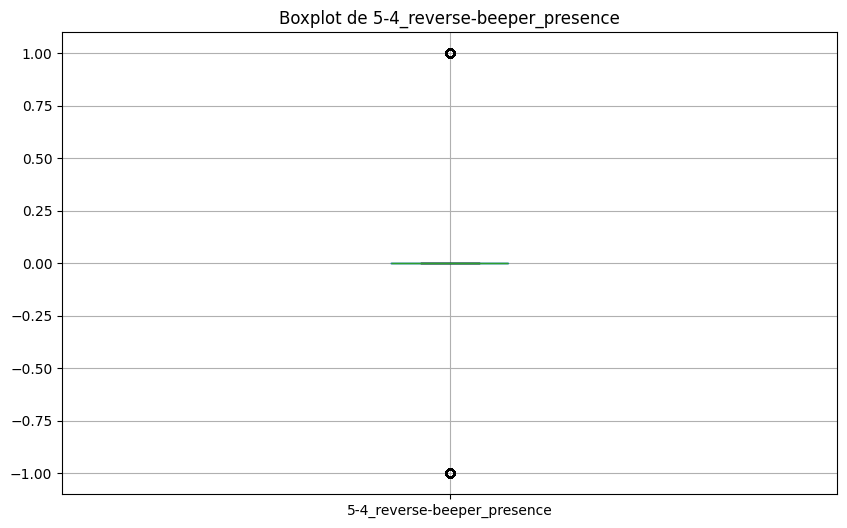

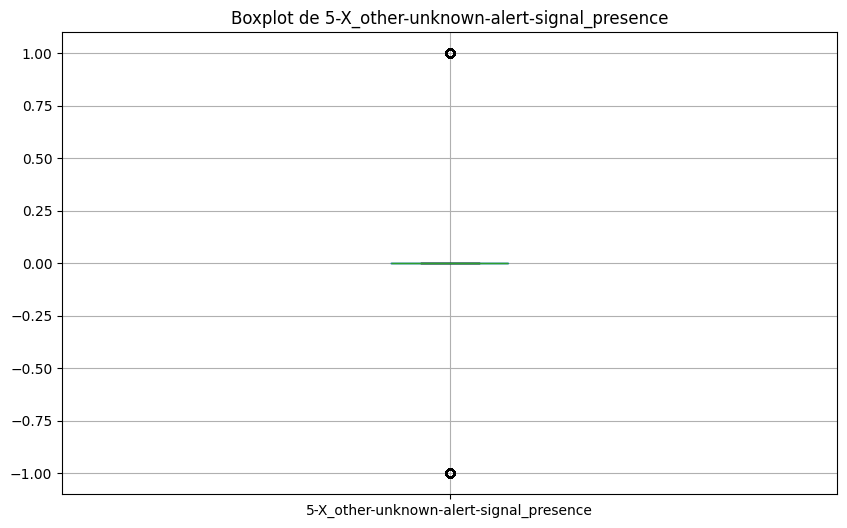

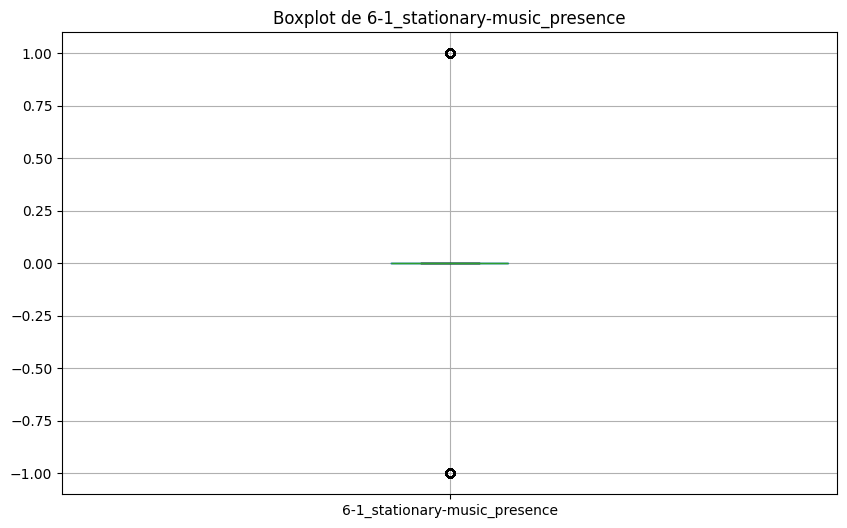

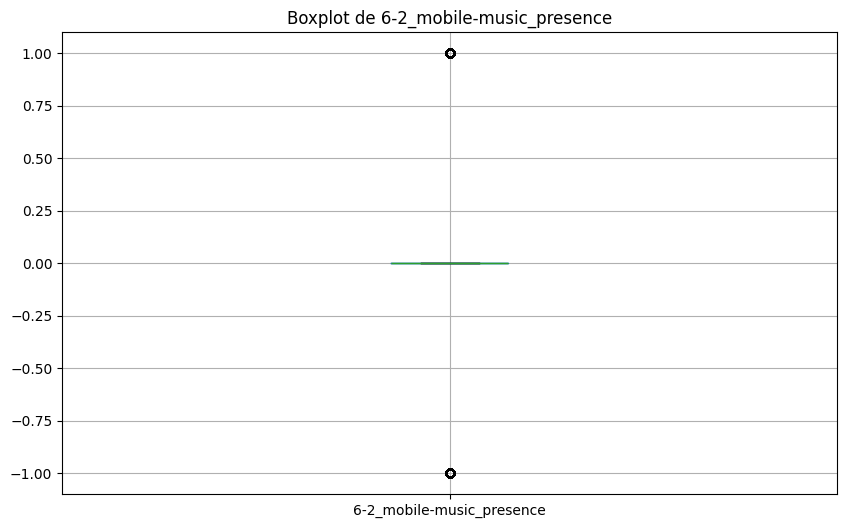

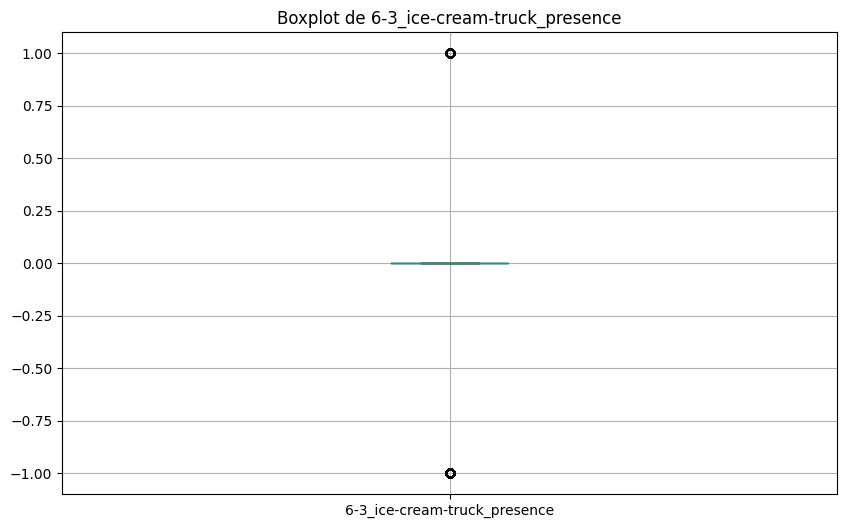

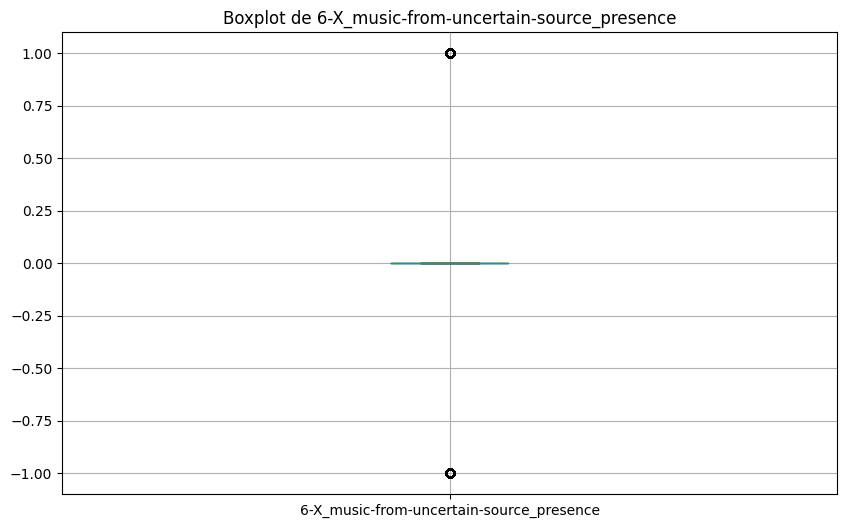

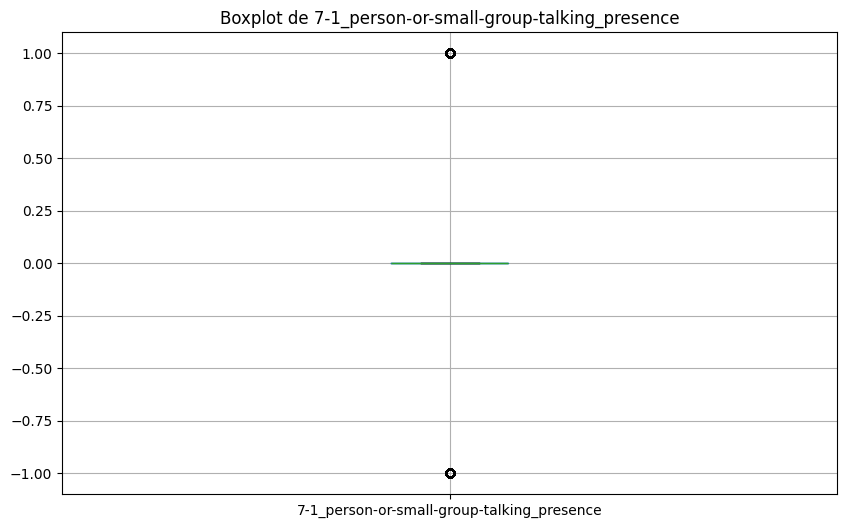

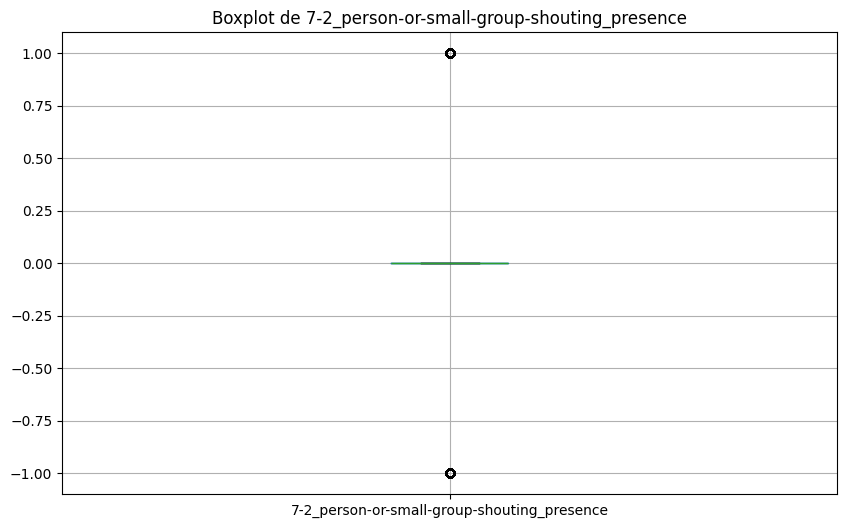

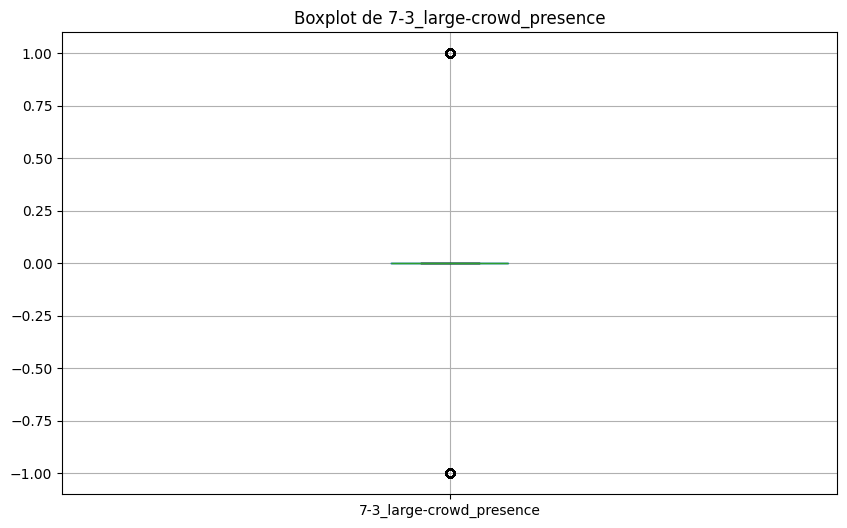

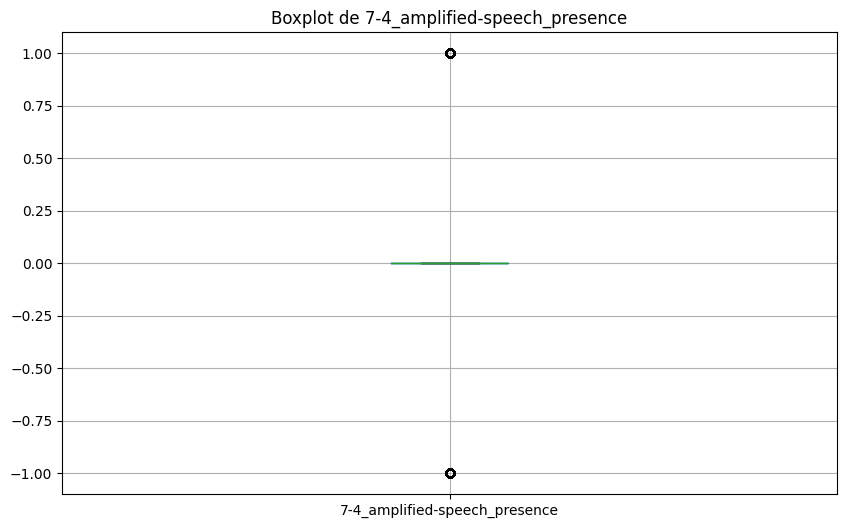

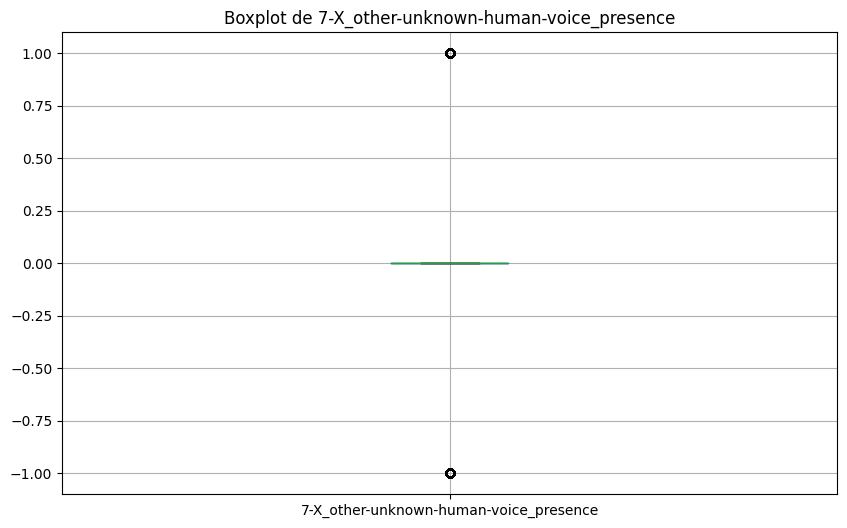

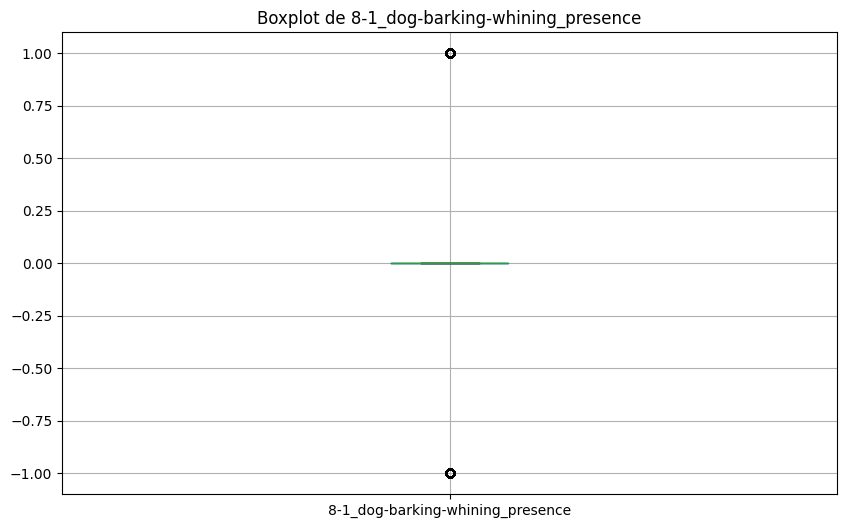

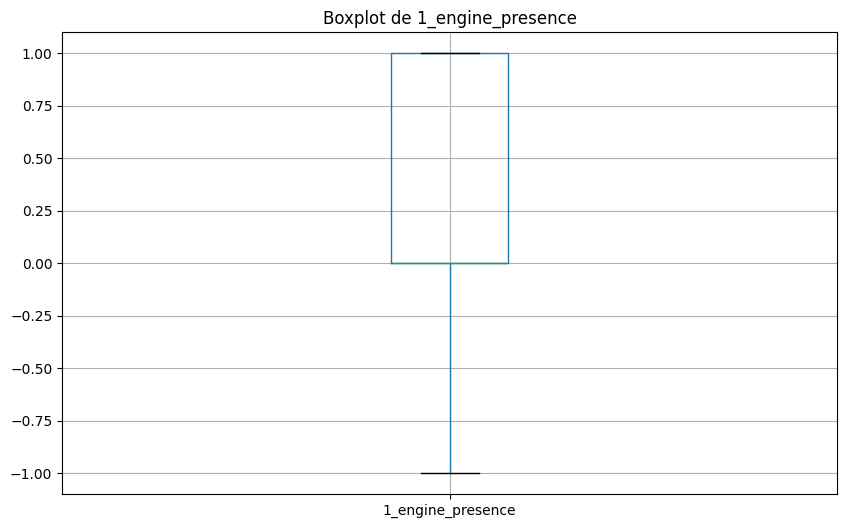

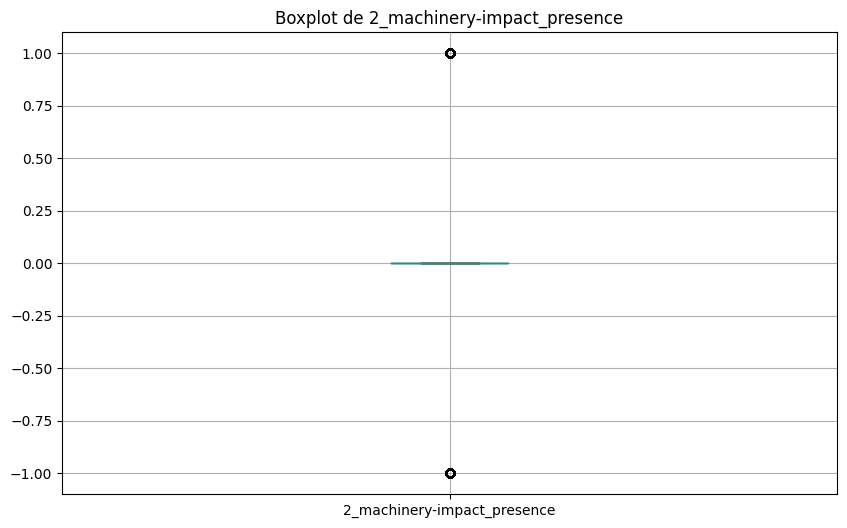

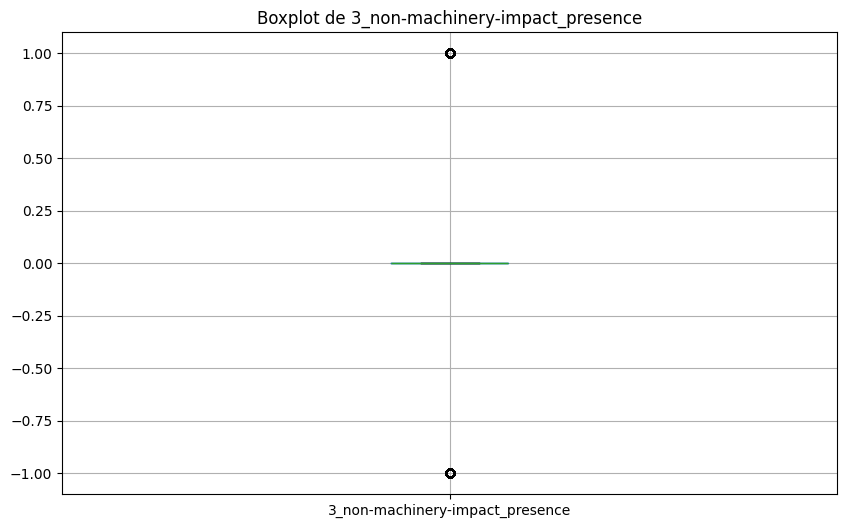

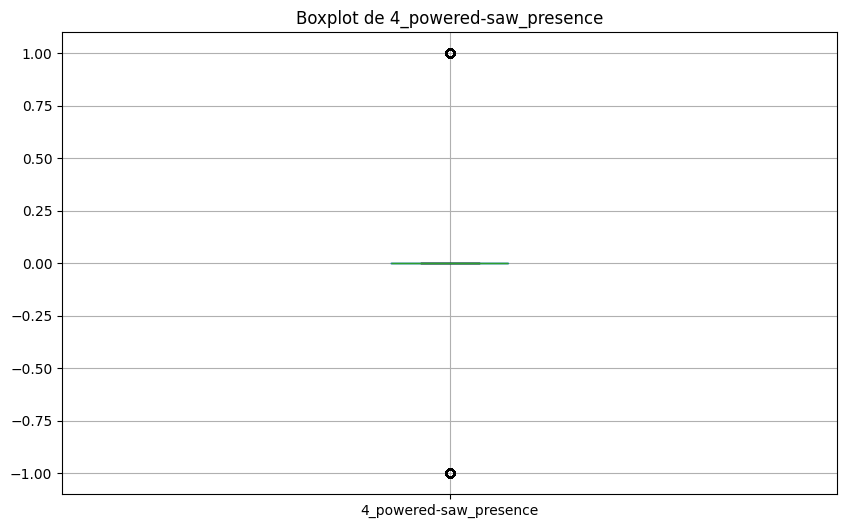

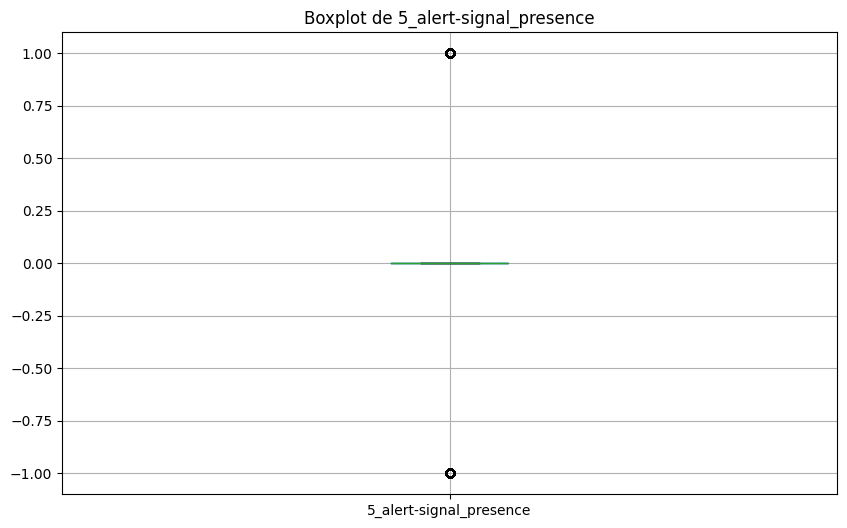

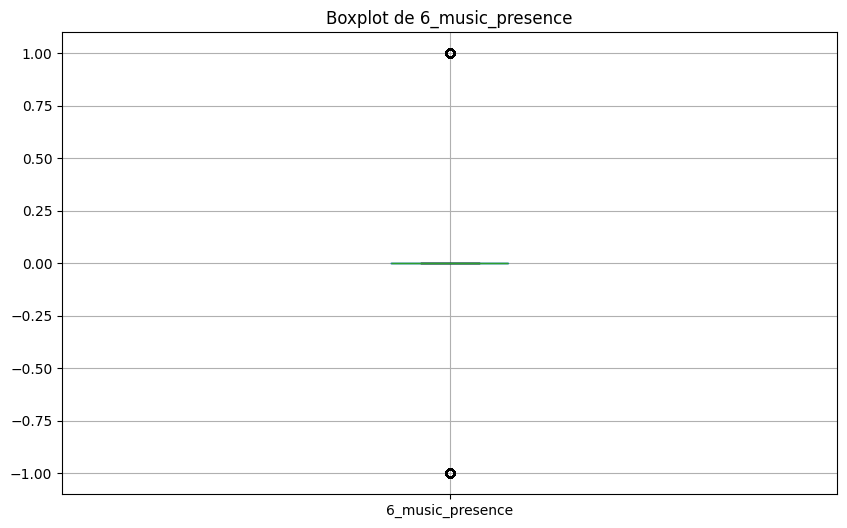

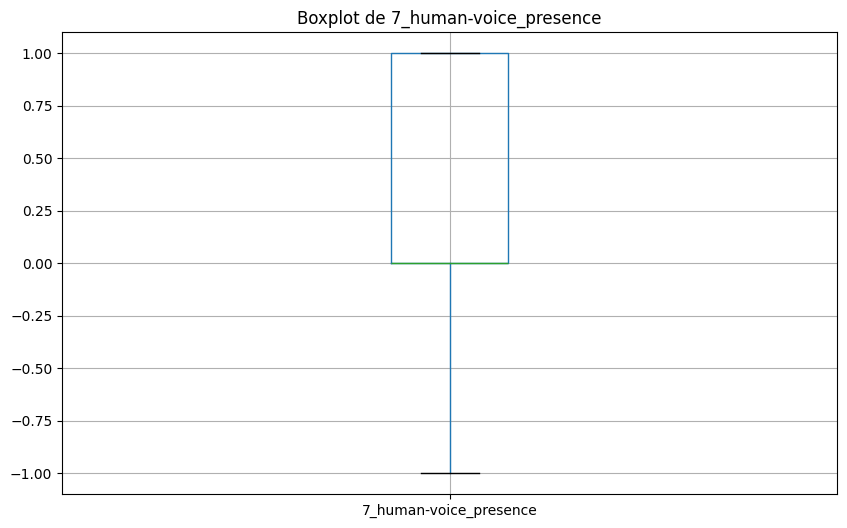

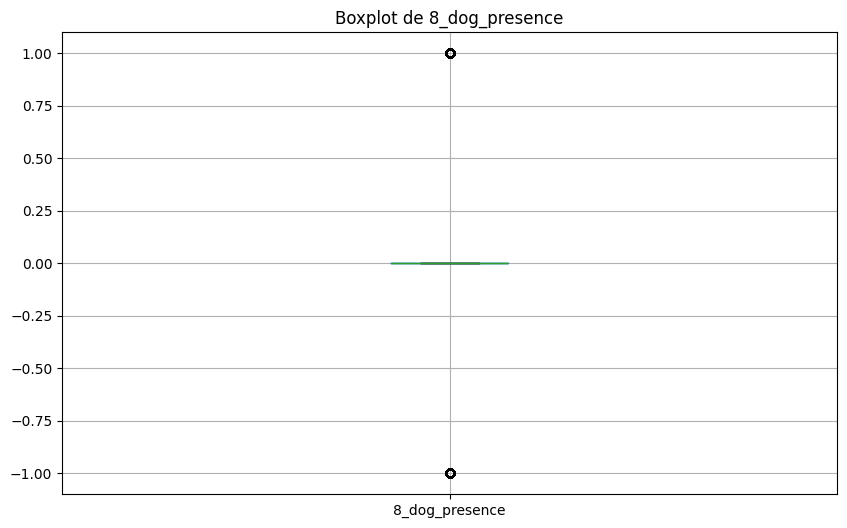

In [6]:
# Columnas numéricas para analizar
numeric_columns = df_annotations.select_dtypes(include=[float, int]).columns

# Crear boxplots para cada columna numérica
for col in numeric_columns:
    plt.figure(figsize=(10, 6))
    df_annotations.boxplot(column=col)
    plt.title(f'Boxplot de {col}')
    plt.show()


In [7]:
# Función para identificar outliers usando IQR
def find_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers


In [9]:
# Identificar outliers para cada columna numérica
for col in numeric_columns:
    outliers = find_outliers_iqr(df_annotations, col)
    print(f"Outliers en {col}:\n", outliers)


Outliers en sensor_id:
 Empty DataFrame
Columns: [split, sensor_id, audio_filename, annotator_id, borough, block, latitude, longitude, year, week, day, hour, 1-1_small-sounding-engine_presence, 1-2_medium-sounding-engine_presence, 1-3_large-sounding-engine_presence, 1-X_engine-of-uncertain-size_presence, 2-1_rock-drill_presence, 2-2_jackhammer_presence, 2-3_hoe-ram_presence, 2-4_pile-driver_presence, 2-X_other-unknown-impact-machinery_presence, 3-1_non-machinery-impact_presence, 4-1_chainsaw_presence, 4-2_small-medium-rotating-saw_presence, 4-3_large-rotating-saw_presence, 4-X_other-unknown-powered-saw_presence, 5-1_car-horn_presence, 5-2_car-alarm_presence, 5-3_siren_presence, 5-4_reverse-beeper_presence, 5-X_other-unknown-alert-signal_presence, 6-1_stationary-music_presence, 6-2_mobile-music_presence, 6-3_ice-cream-truck_presence, 6-X_music-from-uncertain-source_presence, 7-1_person-or-small-group-talking_presence, 7-2_person-or-small-group-shouting_presence, 7-3_large-crowd_presence

In [10]:
# Contar outliers
num_outliers = outliers.shape[0]

print(f"El número total de outliers es: {num_outliers}")

El número total de outliers es: 7452


Se extrae registros de sonidos de los ultimos 5 años y se explayara en los distritos localizados.

In [32]:
# Verifico el tipo de datos de la columna 'year'
print(df_annotations['year'].dtype)


int64


In [37]:
print(df_annotations['year'].unique())


[1970]


In [43]:
df_annotations = pd.read_csv(r'C:\Users\walter\Desktop\Proyecto-NYC-Taxis\Data\annotations.csv', delimiter=',')  


In [44]:
print(df_annotations['year'].unique())


[2019 2017 2016 2018]


In [45]:
# Filtro los datos de los últimos 5 años
end_year = df_annotations['year'].max()
start_year = end_year - 5
filtered_data = df_annotations[(df_annotations['year'] >= start_year) & (df_annotations['year'] <= end_year)]


In [47]:
# Selecciono las columnas que contienen '_presence'
sound_columns = [col for col in df_annotations.columns if '_presence' in col]

In [48]:
# Suma de todas las columnas de sonido para obtener una métrica total
filtered_data['total_sound_emissions'] = filtered_data[sound_columns].sum(axis=1)

In [49]:
# Agrupar los datos por distrito y suma de  las emisiones de sonido
emissions_by_district = filtered_data.groupby('borough')['total_sound_emissions'].sum().reset_index()

# Ver los resultados
print(emissions_by_district)

# Agrupar los datos por año y distrito, y sumar las emisiones de sonido
annual_emissions = filtered_data.groupby(['year', 'borough'])['total_sound_emissions'].sum().unstack().fillna(0)


   borough  total_sound_emissions
0        1                 -20788
1        3                 -15734
2        4                  -1288


Visualización en gráfico de curvas

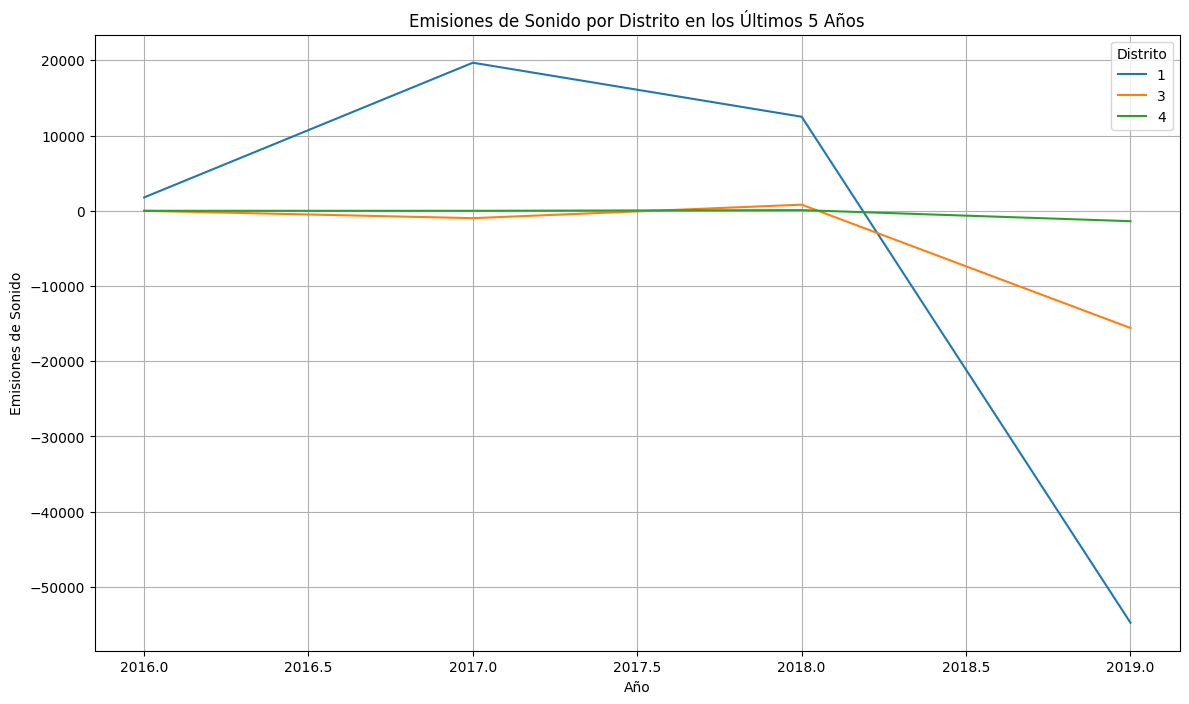

In [50]:
# Creación del gráfico de curvas
annual_emissions.plot(kind='line', figsize=(14, 8))
plt.title('Emisiones de Sonido por Distrito en los Últimos 5 Años')
plt.xlabel('Año')
plt.ylabel('Emisiones de Sonido')
plt.legend(title='Distrito')
plt.grid(True)
plt.show()

In [54]:

# Las columnas de emisiones de sonido están numeradas y empiezan desde '1-1_small-sounding-engine_presence'
# Sumar todas las columnas de emisiones de sonido
emission_columns = [col for col in df_annotations.columns if 'presence' in col]
filtered_data['total_emissions'] = filtered_data[emission_columns].sum(axis=1)

# Agrupar por distrito y sumar las emisiones
district_emissions = filtered_data.groupby('borough')['total_emissions'].sum()

# Encontrar el distrito con más emisiones
max_emissions_district = district_emissions.idxmax()
max_emissions_value = district_emissions.max()

print(f"El distrito con más emisiones de sonido en los últimos 5 años es: {max_emissions_district} con un total de {max_emissions_value} emisiones de sonido.")

El distrito con más emisiones de sonido en los últimos 5 años es: 4 con un total de -1288 emisiones de sonido.


Conclusión: se hayan la cantidad de sonidos dispersados en los ultimos 5 años.